In [177]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = [15, 6]
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [173]:
# Load data
url = 'https://docs.google.com/spreadsheets/d/1-MEOxWn6VeUgFgjzoIRY-d6teP5xS_fr34X5cldbwwY/export?gid=0&format=csv'
data = pd.read_csv(url, error_bad_lines=False)
data['timestamp_arrive'] = pd.to_datetime(data['Date']+' '+data['Line-up Time'])
data['timestamp_depart'] = pd.to_datetime(data['Date']+' '+data['Pick-up Time'])
data = data.rename(columns={'User':'user',
                            'Day of Week':'weekday',
                            '# in Line':'line_count',
                            'Notes':'notes'})
data = data.drop(['Date', 'Line-up Time', 'Pick-up Time'], axis=1)
data['wait_minutes'] = (data['timestamp_depart'] - data['timestamp_arrive']).apply(lambda x: x.total_seconds() / 60)
data['day_of_week'] = data['timestamp_arrive'].dt.dayofweek
start = data['timestamp_arrive'].apply(lambda x: x.date())
start = start.apply(lambda x: datetime.datetime.combine(x, datetime.time(6, 30)))
data['minutes_since_start'] = data['timestamp_arrive'] - start
data['minutes_since_start'] = data['minutes_since_start'].apply(lambda x: x.total_seconds() / 60)
# data['after_eight'] = 0
# data.loc[data.query('minutes_since_start > 90').index, 'after_eight'] = 1
data.head()

,user,weekday,line_count,notes,timestamp_arrive,timestamp_depart,wait_minutes,day_of_week,minutes_since_start
0,Victor,Wednesday,19,NaN,2016-06-08 07:50:00,2016-06-08 08:05:00,15.00,2,80.00
1,Victor,Thursday,4,NaN,2016-06-09 07:26:00,2016-06-09 07:29:00,3.00,3,56.00
2,Mikaela,Thursday,19,Bus arrived as I got in line,2016-06-09 08:01:00,2016-06-09 08:21:00,20.00,3,91.00
3,Victor,Friday,9,NaN,2016-06-10 07:30:00,2016-06-10 07:38:00,8.00,4,60.00
4,Mikaela,Friday,21,Took the bus after 10 minutes,2016-06-10 07:50:00,2016-06-10 08:00:00,10.00,4,80.00


In [142]:
columns = ['line_count', 'timestamp_arrive', 'wait_minutes', 'minutes_since_start']
df = data[columns]
df.head()

,line_count,timestamp_arrive,wait_minutes,minutes_since_start
0,19,2016-06-08 07:50:00,15.00,80.00
1,4,2016-06-09 07:26:00,3.00,56.00
2,19,2016-06-09 08:01:00,20.00,91.00
3,9,2016-06-10 07:30:00,8.00,60.00
4,21,2016-06-10 07:50:00,10.00,80.00


In [145]:
g = df.groupby('minutes_since_start')
d = g.agg('mean')
d = d.reset_index()
d.head()

,minutes_since_start,line_count,wait_minutes
0,7.00,2.00,2.00
1,24.00,0.00,0.00
2,28.00,0.00,0.00
3,31.00,0.50,0.50
4,39.00,0.00,0.00


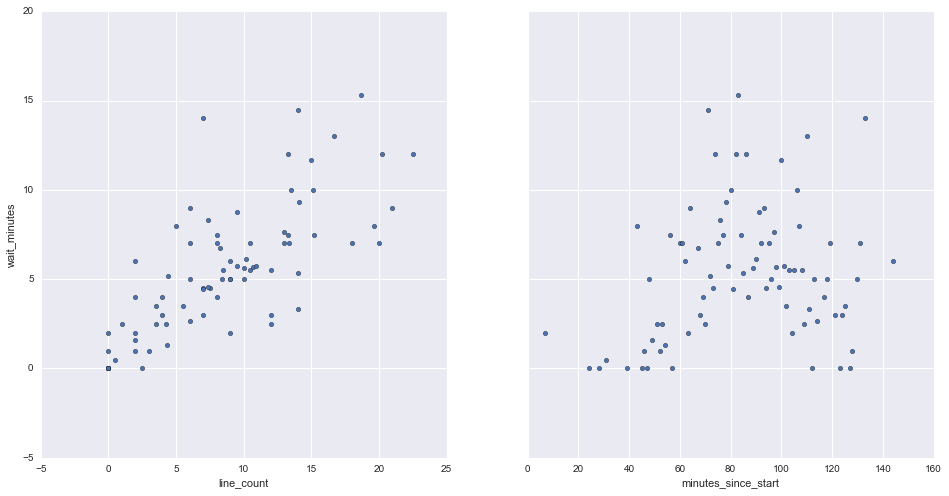

In [148]:
fig, axs = plt.subplots(1, 2, sharey=True)
d.plot(kind='scatter', x='line_count', y='wait_minutes', ax=axs[0], figsize=(16, 8))
d.plot(kind='scatter', x='minutes_since_start', y='wait_minutes', ax=axs[1])

In [151]:
lm = smf.ols(formula='wait_minutes ~ line_count', data=d).fit()
lm.rsquared

0.5795484836290945

In [152]:
lm = smf.ols(formula='wait_minutes ~ minutes_since_start', data=d).fit()
lm.rsquared

0.049449222709134322

In [153]:
lm = smf.ols(formula='wait_minutes ~ line_count + minutes_since_start', data=d).fit()
lm.rsquared

0.58129888610679981

In [154]:
d = d.dropna()

In [156]:
# create X and y
feature_cols = ['line_count', 'minutes_since_start']
X = d[feature_cols]
y = d['wait_minutes']

# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [157]:
lm.intercept_

1.720210690604242

In [158]:
lm.score(X, y)

0.58129888610679981

In [176]:
d2 = df[['timestamp_arrive', 'wait_minutes']]
g2 = d2.groupby('timestamp_arrive')
d2 = g2.agg('mean')
d2.head()

,wait_minutes
timestamp_arrive,
2016-06-08 07:50:00,15.00
2016-06-09 07:26:00,3.00
2016-06-09 08:01:00,20.00
2016-06-10 07:30:00,8.00
2016-06-10 07:50:00,10.00


In [182]:
ts = d2.dropna()

In [178]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [184]:
# p - number of AR terms (lags)
# d - number of nonseasonal differences
# q - number of MA terms (lags)

parameters = [(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 2), (2, 1, 0), (2, 1, 2),
             (0, 2, 0), (0, 2, 1), (1, 2, 0), (2, 2, 0)]
# parameters = [(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
# parameters = [(0, 1, 1)]

optimal = 0
for p in parameters:
    model = ARIMA(ts, order=p)
    results = model.fit()
    print(p)
    print('aic: '+str(results.aic))
    print('bic: '+str(results.bic))

(0, 1, 0)
aic: 1411.45895542
bic: 1418.22794555
(0, 1, 1)
aic: 1270.5562909307077
bic: 1280.70977612
(0, 1, 2)
aic: 1272.4945738029874
bic: 1286.03255405
(1, 1, 0)
aic: 1357.608057648507
bic: 1367.76154284
(1, 1, 2)
aic: 1274.4110728208218
bic: 1291.33354813
(2, 1, 0)
aic: 1332.4915710106538
bic: 1346.02955126
(2, 1, 2)
aic: 1274.1453259880082
bic: 1294.45229636
(0, 2, 0)
aic: 1638.98137763
bic: 1645.74117234
(0, 2, 1)
aic: 1413.3751427066054
bic: 1423.51483477
(1, 2, 0)
aic: 1524.4616962388309
bic: 1534.6013883
(2, 2, 0)
aic: 1464.3330723388026
bic: 1477.85266175


In [185]:
order = (0, 2, 0)
model = ARIMA(ts, order=order)
results = model.fit()

In [189]:
forecast = results.predict(start='2017-02-20', end='2017-03-01', typ='levels')
resdf = pd.concat([ts, forecast], axis=1)
resdf = resdf.rename(columns={'amount':'actual', 0:'forecast'})
resdf.plot()

ValueError: There is no frequency for these dates and date 2017-02-20 00:00:00 is not in dates index. Try giving a date that is in the dates index or use an integer